* https://stackoverflow.com/questions/60758778/sort-data-in-pandas-dataframe-alphabetically
* https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/#:~:text=Python%20Dictionary-,Python%20%7C%20Pandas%20Split%20strings%20into%20two%20List%2FColumns%20using%20str,split()&text=Pandas%20provide%20a%20method%20to,from%20a%20single%20separated%20string.
* https://stackoverflow.com/questions/3136689/find-and-replace-string-values-in-list
* https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html
* https://plotly.com/python/templates/

# Requirements

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

from scipy.stats import chi2_contingency

from dython.nominal import associations

import seaborn as sns
import plotly
import plotly.express as px
import plotly.io as pio
import kaleido # fix with pip install kaleido==0.1.0post1
import matplotlib.pyplot as plt

from raceplotly.plots import barplot
import plotly.figure_factory as ff
import plotly.graph_objects as go 

import datetime as dt
import unicodedata
from wordcloud import WordCloud
import nltk
import emoji
import string
import re

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)

pd.options.display.max_colwidth = 200

# Funções

## Funções de regex

In [2]:
def funcao_tira_acento(df,coluna_antiga, coluna_nova):
    
    df[coluna_antiga] = df[coluna_antiga].astype(str)
    
    df[coluna_nova] = df.apply(lambda row: unicodedata
                       .normalize('NFD', row[coluna_antiga])
                       .encode('ascii', 'ignore')
                       .decode("utf-8"), axis=1)
    
    df[coluna_nova] = df[coluna_nova].str.replace ('[/<>()|\+\-_\$%&#@\'\"]+', ' ', regex=True)

    df[coluna_nova] = df[coluna_nova].str.replace('[,.:;!?]+', ' ', regex=True)
    
    df[coluna_nova] = df[coluna_nova].str.replace('[0-9]+', '', regex=True).copy()
    
    df[coluna_nova] = df[coluna_nova].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwordspt)]))
    
    return df


def tokenize(txt):
    tokens = re.split('\W+', txt)
    return tokens
    
    
def conserta_campo_data(df,campo_original,campo_novo):

    #
    df[campo_novo] = pd.to_datetime(df[campo_original])
    df[campo_novo] = df[campo_novo].dt.strftime('%Y-%m-%d')
    df[campo_novo] = pd.to_datetime(df[campo_novo].astype(str))

    #
    df[campo_original] = pd.to_datetime(df[campo_original])#.dt.strftime('%Y-%m-%d %H:%M:%S')
    
    #
    df[campo_original] = pd.to_datetime(df[campo_original].astype(str))
    
    return df
    

## Função conserta questão

In [3]:
def conserta_questao(df, questao, dfdp):

    df[questao] = df[questao].astype(str)

    df[questao] = df[questao].str.strip()

    # df["q32"] = df[questao].str.split(",", n = 1, expand = False)

    lista_itens = dfdp.depara.unique()

    descricao = dfdp.descricao.unique()

    n = len(descricao)

    for i in range(n):
        df[questao] = df[questao].str.replace(descricao[i], lista_itens[i], regex=True)
    
    return df, lista_itens

## Função genérica de cálculo de frequência da questão ajustada

In [4]:
def funcao_ajuste(df, lista_itens):
    
    questao = list(df.columns)
    
    questao = questao[0]
    
    df['token'] = df[questao].apply(lambda x: tokenize(x.lower()))

    #
    for x in lista_itens:
        df[x] = False

    for x in lista_itens:
        df[x] = df.apply(lambda row: x in row['token'], axis=1)

    df = pd.melt(df, id_vars = questao, value_vars = lista_itens).rename(columns = {'variable':'resposta'})

    df = df.groupby(['resposta']).agg(freq = ('value','sum')).reset_index()

    df['percentual'] = round(df['freq']*100/df['freq'].sum(),2)

    return df

## Printa o gráfico da distribuição de respostas

In [5]:
def grafico_respostas(df, k, x_size, y_size):
        
    tb = df.groupby([k]).agg(freq = (k,'count')).reset_index()

    tb['percentual'] = round(tb['freq']*100/tb['freq'].sum(),2)

    # Horizontal Bar Plot usando seaborn
    #y = tb[k]
    #x = tb['freq']
    #fig, ax = plt.subplots(figsize =(x_size, y_size))
    #ax = sns.barplot(x = x, y = y, data = df)
    #ax.bar_label(ax.containers[0])   
    # fig.show()

    #
    fig = px.bar(tb, 
                 x = 'percentual', 
                 y = k,
                 text_auto = '.2s', 
                 title = 'Distribuição de frequência das respostas (%)',
                 width = x_size,
                 height = y_size
                )

    #
    fig.update_layout(yaxis = {'categoryorder':'total ascending'}, template = 'plotly')
   
    # Estilos de plot
    # https://plotly.com/python/templates/
    #'ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
    #'ygridoff', 'gridon', 'none'
    

    return tb, fig #, ax

## Função plota gráfico das questões ajustadas

In [6]:
def grafico_respostas_ajustadas(df, x_size, y_size):

    #
    fig = px.bar(df, 
                 x = 'freq', 
                 y = 'descricao',
                 text_auto = '.2s', 
                 title = 'Distribuição de frequência das respostas',
                 width = x_size,
                 height = y_size
                )

    #
    fig.update_layout(yaxis = {'categoryorder':'total ascending'}, template = 'plotly')
   
    # Estilos de plot
    # https://plotly.com/python/templates/
    #'ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
    #'ygridoff', 'gridon', 'none'
    

    return fig #, ax

## Gera todos os gráficos num loop for (falta transformar em função)

## Função que constrói dataframe de correlações

In [7]:
def funcao_constroi_tb_corr(df, lista_questoes,k):

    lista_cols_aux = lista_questoes[:k]

    aux = df[lista_cols_aux].copy()

    tb_corr = associations(aux, 
                 nominal_columns='auto', 
                 numerical_columns=None, 
                 mark_columns=False, 
                 nom_nom_assoc='cramer', 
                 num_num_assoc='pearson', 
                 #bias_correction=True, 
                 #nan_strategy=_REPLACE, 
                 #nan_replace_value=_DEFAULT_REPLACE_VALUE, 
                 ax=None, 
                 figsize=(12,12), 
                 annot=True, 
                 fmt='.2f', 
                 cmap=None, 
                 sv_color='silver', 
                 cbar=True, 
                 vmax=1.0, 
                 vmin=None, 
                 plot=True, 
                 compute_only=False, 
                 clustering=False, 
                 title=None, 
                 filename=None
                )

    #
    tb_corr = pd.DataFrame(tb_corr['corr']).reset_index()

    #
    tb_corr = tb_corr[lista_cols_aux]

    #
    return tb_corr, lista_cols_aux

# Get data

In [8]:
#
df = pd.read_excel('respostas.xlsx',sheet_name = 'DataSimplif')

#
dp = pd.read_excel('respostas.xlsx',sheet_name = 'dp')

#
dpq7 = pd.read_excel('respostas.xlsx',sheet_name = 'dpq7')

#
dpq8 = pd.read_excel('respostas.xlsx',sheet_name = 'dpq8')

#
dpq11 = pd.read_excel('respostas.xlsx',sheet_name = 'dpq11')

#
dpq32 = pd.read_excel('respostas.xlsx',sheet_name = 'dpq32')

#
dpq34 = pd.read_excel('respostas.xlsx',sheet_name = 'dpq34')

#
dpq35 = pd.read_excel('respostas.xlsx',sheet_name = 'dpq35')

#
dpq62 = pd.read_excel('respostas.xlsx',sheet_name = 'dpq62')

#
dpq64 = pd.read_excel('respostas.xlsx',sheet_name = 'dpq64')

#
dpq86 = pd.read_excel('respostas.xlsx',sheet_name = 'dpq86')

# Gráfico da questão 7 (ajustada)

In [9]:
dfx, lista_itens7 = conserta_questao(df, 'q7', dpq7)

df7 = dfx[['q7']]

df7 = funcao_ajuste(df7, lista_itens7)

df7 = pd.merge(df7, dpq7, how = 'left', left_on = 'resposta', right_on = 'depara')

figq7 = grafico_respostas_ajustadas(df7, 1000, 800)

figq7

# Gráfico da questão 8 ajustada

In [10]:
dfx, lista_itens8 = conserta_questao(df, 'q8', dpq8)

df8 = dfx[['q8']]

df8 = funcao_ajuste(df8, lista_itens8)

df8 = pd.merge(df8, dpq8, how = 'left', left_on = 'resposta', right_on = 'depara')

figq8 = grafico_respostas_ajustadas(df8, 1000, 800)

figq8

# Gráfico da questão 11 (ajustada)

In [11]:
dfx, lista_itens11 = conserta_questao(df, 'q11', dpq11)

df11 = dfx[['q11']]

df11 = funcao_ajuste(df11, lista_itens11)

df11 = pd.merge(df11, dpq11, how = 'left', left_on = 'resposta', right_on = 'depara')

figq11 = grafico_respostas_ajustadas(df11, 1000, 1100)

figq11

# Gráfico da questão 32 (ajustada)

In [12]:
dfx, lista_itens32 = conserta_questao(df, 'q32', dpq32)

df32 = dfx[['q32']]

df32 = funcao_ajuste(df32, lista_itens32)

df32 = pd.merge(df32, dpq32, how = 'left', left_on = 'resposta', right_on = 'depara')

figq32 = grafico_respostas_ajustadas(df32, 1000, 800)

figq32

# Gráfico da questão 34 (ajustada)

In [13]:
dfx, lista_itens34 = conserta_questao(df, 'q34', dpq34)

df34 = dfx[['q34']]

df34 = funcao_ajuste(df34, lista_itens34)

df34 = pd.merge(df34, dpq34, how = 'left', left_on = 'resposta', right_on = 'depara')

figq34 = grafico_respostas_ajustadas(df34, 1000, 800)

figq34

# Gráfico da questão 35 (ajustada)

In [14]:
dfx, lista_itens35 = conserta_questao(df, 'q35', dpq35)

df35 = dfx[['q35']]

df35 = funcao_ajuste(df35, lista_itens35)

df35 = pd.merge(df35, dpq35, how = 'left', left_on = 'resposta', right_on = 'depara')

figq35 = grafico_respostas_ajustadas(df35, 1000, 800)

figq35

# Gráfico da questão 62 (ajustada)

In [15]:
dfx, lista_itens62 = conserta_questao(df, 'q62', dpq62)

df62 = dfx[['q62']]

df62 = funcao_ajuste(df62, lista_itens62)

df62 = pd.merge(df62, dpq62, how = 'left', left_on = 'resposta', right_on = 'depara')

figq62 = grafico_respostas_ajustadas(df62, 1000, 800)

figq62

# Gráfico da questão 64 (ajustada)

In [16]:
dfx, lista_itens64 = conserta_questao(df, 'q64', dpq64)

df64 = dfx[['q64']]

df64 = funcao_ajuste(df64, lista_itens64)

df64 = pd.merge(df64, dpq64, how = 'left', left_on = 'resposta', right_on = 'depara')

figq64 = grafico_respostas_ajustadas(df64, 1000, 800)

figq64

# Gráfico da questão 86 (ajustada)

In [17]:
dfx, lista_itens86 = conserta_questao(df, 'q86', dpq86)

df86 = dfx[['q86']]

df86 = funcao_ajuste(df86, lista_itens86)

df86 = pd.merge(df86, dpq86, how = 'left', left_on = 'resposta', right_on = 'depara')

figq86 = grafico_respostas_ajustadas(df86, 1000, 800)

figq86

# Gera os gráficos das questões que não precisam de ajustes

In [18]:
#
df1 = df.drop(columns = ['q7','q8','q11','q32','q34','q35','q62','q64','q86'])

#
listaquest = list(df1.columns)

#
for k in listaquest:
    
    globals()[f'tb{k}'], globals()[f'fig{k}'] = grafico_respostas(df1, k, 1000, 800)
    #globals()[f'fig{k}'].write_image(f'fig{k}.png', engine = 'kaleido')
    # pio.write_image(globals()[f'fig{k}'], f'fig{k}', format='png')

# Salva gráficos das questões

In [19]:
#
listaquest = list(df.columns)

#
for k in listaquest:
    
    globals()[f'fig{k}'].write_image(f'fig{k}.png', engine = 'kaleido')

# Plota os gráficos das questões

# tabela de correlações

In [20]:
lista_questoes = df.columns

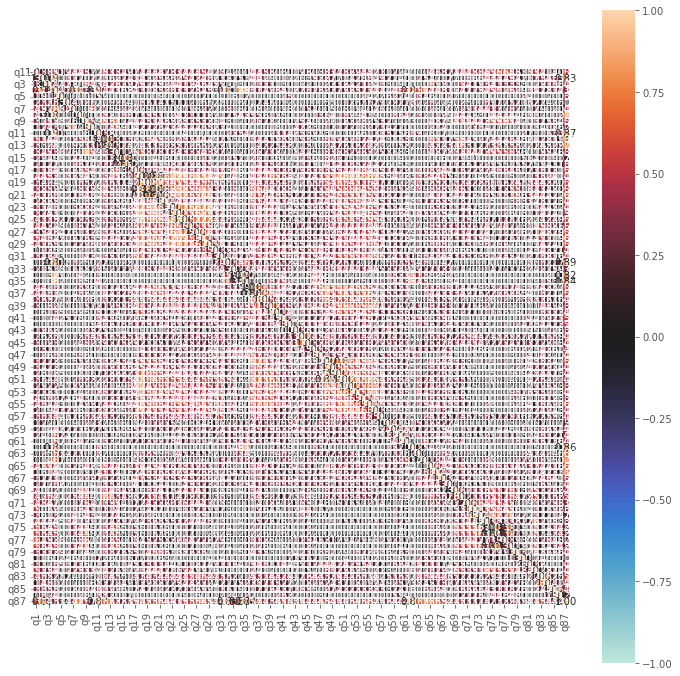

In [21]:
tb_corr, lista_cols_aux = funcao_constroi_tb_corr(df, lista_questoes,len(lista_questoes))

In [22]:
tb_corr

q1        q2        q3        q4        q5        q6        q7  \
0   1.000000  0.295734  0.309180  0.510005  0.194035  0.234281  0.492222   
1   0.295734  1.000000  0.070375  0.896226  0.000000  0.318235  0.365785   
2   0.309180  0.070375  1.000000  0.435793  0.120906  0.380377  0.195133   
3   0.510005  0.896226  0.435793  1.000000  0.419133  0.331781  0.675574   
4   0.194035  0.000000  0.120906  0.419133  1.000000  0.000000  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
82  0.403421  0.352930  0.274428  0.277764  0.122547  0.143255  0.000000   
83  0.143388  0.396027  0.300667  0.174759  0.000000  0.066681  0.000000   
84  0.296134  0.351209  0.377706  0.322325  0.000000  0.078719  0.197106   
85  0.000000  0.320196  0.000000  0.408838  0.000000  0.000000  0.000000   
86  0.550917  0.830499  0.432271  0.373387  0.342571  0.169299  0.422901   

          q8        q9       q10       q11       q12       q13       q14  \
0   0.451233  0.370937  0.120889  0.000000  0.507705  0.331781  0.340873   
1   0.201035  0.014758  0.222821  0.000000  0.360190  0.000000  0.268358   
2   0.000000  0.522253  0.428338  0.000000  0.421103  0.277639  0.528978   
3   0.824434  0.379319  0.302927  0.912871  0.416840  0.409904  0.355355   
4   0.000000  0.000000  0.151734  0.188319  0.000000  0.000000  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
82  0.000000  0.251243  0.000000  0.160661  0.284353  0.453537  0.353735   
83  0.000000  0.163719  0.082304  0.130256  0.211702  0.201627  0.240181   
84  0.000000  0.341727  0.258919  0.300750  0.394402  0.288086  0.256312   
85  0.255367  0.000000  0.000000  0.378048  0.133791  0.202953  0.000000   
86  0.785706  0.513156  0.263776  0.870435  0.661481  0.719419  0.379019   

         q15       q16       q17       q18       q19       q20       q21  \
0   0.291657  0.271764  0.172392  0.436615  0.337332  0.376908  0.470353   
1   0.244304  0.171862  0.376795  0.432394  0.203980  0.252075  0.355117   
2   0.293839  0.208998  0.291257  0.521288  0.240986  0.391875  0.303220   
3   0.083220  0.214149  0.431213  0.303901  0.182318  0.250978  0.304034   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.092978  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
82  0.000000  0.143010  0.308849  0.302807  0.428944  0.339042  0.442191   
83  0.192875  0.131577  0.131908  0.285631  0.277711  0.184508  0.272482   
84  0.000000  0.114298  0.208602  0.408012  0.204147  0.199737  0.224911   
85  0.170959  0.163425  0.000000  0.000000  0.000000  0.000000  0.000000   
86  0.210283  0.389953  0.502710  0.418452  0.525403  0.550470  0.655062   

         q22       q23       q24       q25       q26       q27       q28  \
0   0.276643  0.368346  0.371645  0.412201  0.436856  0.346019  0.495649   
1   0.255980  0.299561  0.252301  0.368754  0.431494  0.220086  0.401477   
2   0.252609  0.396143  0.410726  0.394722  0.243285  0.458633  0.335866   
3   0.203477  0.371305  0.329757  0.323403  0.283024  0.342698  0.245487   
4   0.000000  0.000000  0.000000  0.070917  0.000000  0.065188  0.203459   
..       ...       ...       ...       ...       ...       ...       ...   
82  0.370679  0.435802  0.409377  0.415116  0.503521  0.475268  0.515944   
83  0.172628  0.254286  0.236949  0.238404  0.381362  0.268539  0.301988   
84  0.231562  0.217522  0.212480  0.286545  0.263364  0.293514  0.187764   
85  0.000000  0.000000  0.092400  0.000000  0.156794  0.000000  0.000000   
86  0.494437  0.470647  0.390462  0.525199  0.498891  0.544007  0.610682   

         q29       q30       q31       q32       q33       q34       q35  \
0   0.418053  0.000000  0.344251  0.000000  0.202718  0.000000  0.000000   
1   0.359167  0.233242  0.180593  0.215514  0.152774  0.125227  0.097665   
2   0.351619  0.254565  0.271129  0.000000  0.133953  0.000000  0.000000   
3   0.329970  0.094180  0.431071  0.837037  0.176023  